In [1]:
library(dplyr)
library(ggplot2)
library(bedr)
library(Biostrings)
library(stringr)
library(lessR)
# library(SeuratDisk)
library(Seurat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




######################
#### bedr v1.0.7 ####
######################

checking binary availability...
  * Checking path for bedtools... PASS
    /usr/local/bin/bedtools
  * Checking path for bedops... PASS
    /home/vsevim/software/anaconda3/bin/bedops
  * Checking path for tabix... PASS
    /usr/local/bin/tabix
tests and examples will be skipped on R CMD check if binaries are missing


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, d

In [2]:
ADD_GUIDE_A_B_COUNTS_BEFORE_DEMUX = FALSE

In [3]:
# Pass these as parameters
# library      = "CRISPR7"
# tsv_path <- "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/CRISPR7/tsv"
# h5_name  <- "/home/vsevim/prj/tf/CATATAC_4/analysis/secondary/CRISPR7/seurat/CATATAC_4_CRISPR7_ONLY_SINGLETS.h5seurat"
# protosp_path = "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/CRISPR7/resources/protospacers_4set.tsv"

In [4]:
barcode2guide_tsv_path <- paste0(tsv_path, "/", library, "_ALL_STRUCTURED.TSV")
xlsname <- paste0(tsv_path, "/", library, "_PIVOT.xlsx")
tsvname <- paste0(tsv_path, "/", library, "_PIVOT.TSV")

In [5]:
stats <- c()

In [6]:
barcode2guide_tsv_path

[1] "/home/vsevim/prj/tf/CATATAC_4/analysis/primary/CRISPR7/tsv/CRISPR7_ALL_STRUCTURED.TSV"

## Load protospacer file

In [7]:
df_protosp = read.table(protosp_path, header=TRUE, comment.char="")
tfs_w_ntctl    = unique(df_protosp$X.TargetGene)
unselect_ntctl = (tfs_w_ntctl != "NTCTL") & (tfs_w_ntctl != "NTCTRL")
tfs_to_plot    = tfs_w_ntctl[unselect_ntctl]

guides_to_plot  = df_protosp$GuideName
tfs_to_plot
guides_to_plot

[1] "GATA5"   "MEOX1"   "NEUROG2"

[1] "GATA5_1"   "GATA5_2"   "MEOX1_1"   "MEOX1_2"   "NEUROG2_1" "NEUROG2_2"
[7] "NTCTL_1"   "NTCTL_2"

# Load and analyze guide capture

In [8]:
df_barcode2guide <-
    read.table(barcode2guide_tsv_path, header = TRUE, sep = "\t", quote = "")

df_barcode2guide <-
    data.frame(lapply(df_barcode2guide, trimws), stringsAsFactors = FALSE)

stats[["Guide-capture UMI counts"]] <- nrow(df_barcode2guide)

# Some ATAC barcodes are not associated with a GEX barcode
# I think those are just sequencing errors. I remove those from the list
select_valid_barcodes <- df_barcode2guide$barcode != ""
df_barcode2guide <- df_barcode2guide[select_valid_barcodes, ]

stats[["Guide-capture UMI counts after removing empty barcodes"]] <-
    nrow(df_barcode2guide)

# Append "-1" to the barcodes. Cellranger appends this number to distinguish
# different samples in aggregated files.
dummy  <- DNAStringSet(df_barcode2guide$barcode)
df_barcode2guide$barcode_dash <- paste0(dummy, "-1")

### Eliminate PCR duplicates of the UMIs from the same barcode

In [9]:
# I already deduplicated guide umis. No more dedup is necessary.
df_deduped <- df_barcode2guide

# df_deduped <- df_barcode2guide %>% distinct(gene, umi, .keep_all = TRUE)

stats[["Guide-capture UMI counts after removing PCR duplicates"]] <-
    nrow(df_deduped)

# dim(df_deduped)

In [10]:
head(df_deduped)

,atac_barcode,umi,protospacer,guide,gene,read_name,barcode,barcode_dash
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TAGGTGAGTCCTCCCA,AAGGCCTGACAG,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:12952:1407,GACCGTTCATAACGGG,GACCGTTCATAACGGG-1
2,TGTCTTGAGATTCTGT,TTTATTTTTCTT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:17472:3850,TGCTGGATCGATATTG,TGCTGGATCGATATTG-1
3,TGTCTTGAGATTCTGT,TTTATTTTTCTT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:18313:6120,TGCTGGATCGATATTG,TGCTGGATCGATATTG-1
4,CACAACCTCGCAATTT,ATACTAGTTTCT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:1597:9017,GTGAACAAGTTATCTC,GTGAACAAGTTATCTC-1
5,GGTAACTAGCTAATCT,ACGCACTGCATC,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:32705:9220,CCTATATTCATGCGTG,CCTATATTCATGCGTG-1
6,GCATATTTCAGGATCG,CTTTAGTTTGGA,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:1506:10927,TGGACAAAGTGAGGTA,TGGACAAAGTGAGGTA-1


# Build a df for all barcodes

Summerizing the umi counts, guide counts etc. Find the barcodes that are associated with multiple genes.

In [11]:
# Build two new dfs to summerize guide and gene counts
df_gene_counts <- pivot(df_deduped, table, gene, barcode)
df_guide_counts <- pivot(df_deduped, table, guide, barcode)

# Drop unused columns
df_gene_counts <- select(df_gene_counts, -gene_na, -gene_n)
if(ADD_GUIDE_A_B_COUNTS_BEFORE_DEMUX){
    df_guide_counts <- select(df_guide_counts, -guide_na)
} else {
    df_barcodes <- select(df_guide_counts, -guide_na)
}

# Merge guide and gene columns
if(ADD_GUIDE_A_B_COUNTS_BEFORE_DEMUX) {
    df_barcodes <- merge(df_gene_counts, df_guide_counts, by = "barcode")
}

# n_guides is umi count
df_barcodes <- dplyr:::rename(df_barcodes, n_guides = guide_n)

# Add a "-1" to barcode names to match with multiome barcode
# names from cellranger.
dummy  <- DNAStringSet(df_barcodes$barcode)
df_barcodes$barcode_dash <- paste0(dummy, "-1")


In [12]:
head(df_barcodes, 2)

,barcode,n_guides,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2,barcode_dash
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAACAGCCAATTAAGG,1,0,0,1,0,0,0,0,0,AAACAGCCAATTAAGG-1
2,AAACAGCCACACTAAT,1,0,0,1,0,0,0,0,0,AAACAGCCACACTAAT-1


In [13]:
colnames(df_barcodes)

[1] "barcode"      "n_guides"     "GATA5_1"      "GATA5_2"      "MEOX1_1"     
 [6] "MEOX1_2"      "NEUROG2_1"    "NEUROG2_2"    "NTCTL_1"      "NTCTL_2"     
[11] "barcode_dash"

# Load multiome data

In [14]:
seurat <- readRDS(h5_name)

Validating h5Seurat file

Loading required package: Signac



### Intersect guide-capture barcodes with multiome barcodes

In [15]:
# Find overlapping barcodes
multiome_barcodes       <- Cells(seurat)
df_barcodes$in_multiome <- df_barcodes$barcode_dash %in% multiome_barcodes

In [16]:
nrow(seurat)
length(multiome_barcodes)
head(multiome_barcodes)
nrow(seurat@meta.data)
#str(seurat)
length(Cells(seurat))

[1] 28158

[1] 14977

[1] "AAACAGCCACATTGCA-1" "AAACAGCCAGGCATGA-1" "AAACAGCCAGTTATGT-1"
[4] "AAACAGCCATAAACCT-1" "AAACAGCCATGGCCTG-1" "AAACAGCCATTAAAGG-1"

[1] 14977

[1] 14977

In [17]:
sample_n(df_barcodes, 5)

barcode,n_guides,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2,barcode_dash,in_multiome
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
GTAGTTTCAGCAACAG,2,0,0,0,0,1,0,1,0,GTAGTTTCAGCAACAG-1,FALSE
AACGCCCAGACTAAGG,3,3,0,0,0,0,0,0,0,AACGCCCAGACTAAGG-1,FALSE
GAGCGAAGTTAGTACG,1,0,0,0,0,1,0,0,0,GAGCGAAGTTAGTACG-1,FALSE
CAAGGTAAGTTATTCC,1,0,0,0,0,0,0,1,0,CAAGGTAAGTTATTCC-1,FALSE
CACTAAGGTAGCCATA,3,0,0,1,0,1,1,0,0,CACTAAGGTAGCCATA-1,FALSE


Write df_barcodes to TSV and XLS

In [18]:
library(writexl)
write_xlsx(df_barcodes, xlsname)
write.table(df_barcodes, tsvname, sep = "\t", quote = FALSE, row.names = FALSE)

# Produce charts

In [19]:
select_gt1_umi_per_cell <- df_barcodes$n_guides > 1
select_convergent       <- df_barcodes$targeted_gene_count == 1

df_barcodes_gt1         <- df_barcodes[select_gt1_umi_per_cell, ]
df_in_multiome          <- df_barcodes[df_barcodes$in_multiome, ]
df_gt1_in_multiome      <- df_barcodes_gt1[df_barcodes_gt1$in_multiome, ]
df_convergent           <- df_barcodes[select_convergent, ]

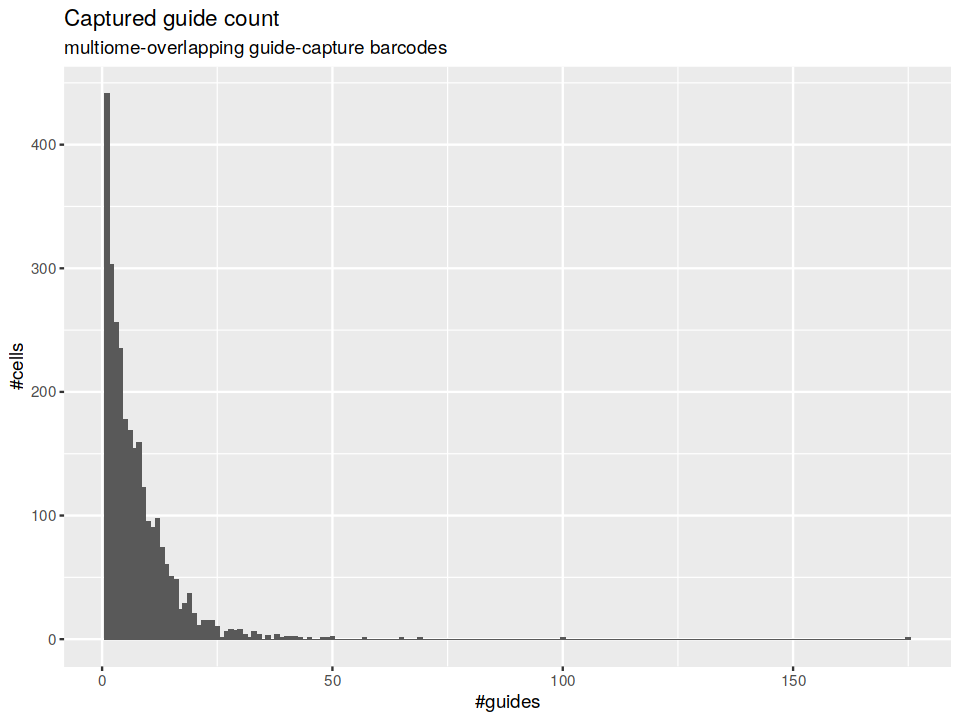

In [20]:
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(df_in_multiome, aes(x = n_guides)) +
    geom_histogram(binwidth=1) +
    labs(title = "Captured guide count", x = "#guides")+
    labs(subtitle = "multiome-overlapping guide-capture barcodes", y = "#cells")
    

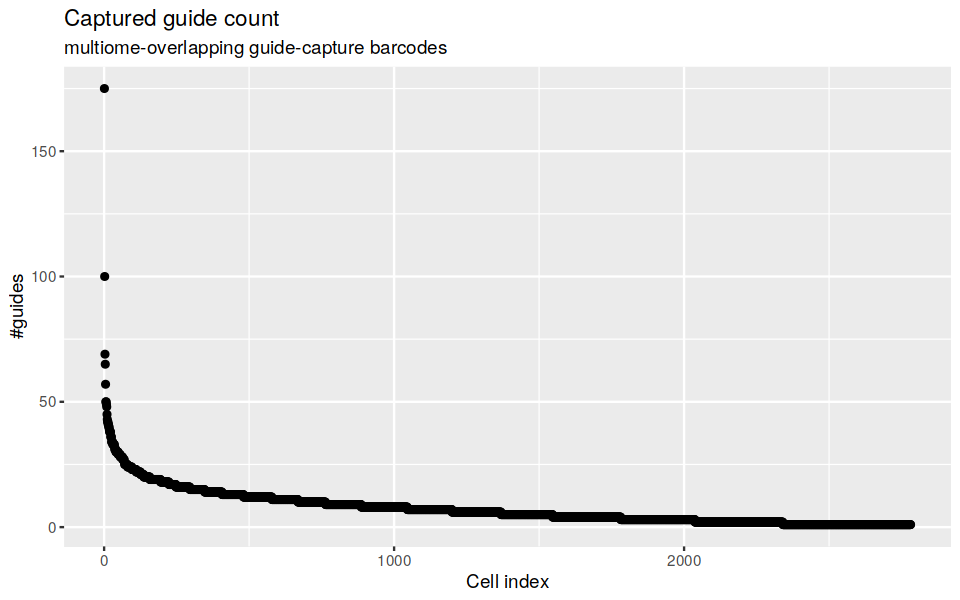

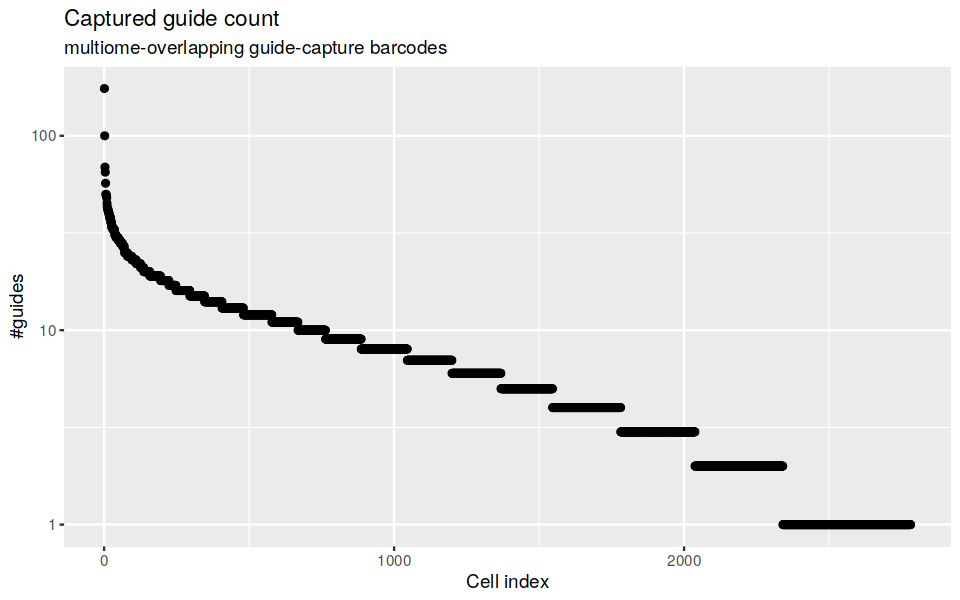

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5)
df_dummy <- df_in_multiome[order(-df_in_multiome$n_guides),]

ggplot(df_dummy, aes(x=1:nrow(df_dummy), y = n_guides)) +
    geom_point() +
    labs(title = "Captured guide count", x = "Cell index") +
    labs(subtitle = "multiome-overlapping guide-capture barcodes", y = "#guides")

ggplot(df_dummy, aes(x=1:nrow(df_dummy), y = n_guides)) +
    geom_point() +
    labs(title = "Captured guide count", x = "Cell index") +
    labs(subtitle = "multiome-overlapping guide-capture barcodes", y = "#guides") +
    scale_y_log10()

In [26]:
# Record stats
stats[["%overlapping"]] <-
    100 * sum(df_barcodes$in_multiome) / length(multiome_barcodes)

stats[["Guide-capture barcodes"]] <- nrow(df_barcodes)
stats[["Multiome barcodes"]]      <- length(multiome_barcodes)
stats[["Overlapping barcodes"]]   <- sum(df_barcodes$in_multiome)
stats[["Overlapping barcodes > 1 UMI"]] <- sum(df_barcodes_gt1$in_multiome)
stats[["Guide capture all convergent"]] <- nrow(df_convergent)
stats[["Guide capture overlapping convergent"]] <-
    sum(df_convergent$in_multiome)
stats[["Median guides per cell (multiome-overlapping)"]] <- median(df_in_multiome$n_guides)

# Print stats

In [27]:
for (tag in names(stats)) {
    if (tag != "Capture efficiency") {
        text <- sprintf("%s\t%g\n", tag, stats[[tag]])
    }
    else {
        text <- sprintf("%s\t%.1f%%\n", tag, stats[[tag]])
    }
    cat(text)
}

Guide-capture UMI counts	60579
Guide-capture UMI counts after removing empty barcodes	59226
Guide-capture UMI counts after removing PCR duplicates	59226
Median guides per cell (multiome-overlapping)	5
%overlapping	18.5685
Guide-capture barcodes	19069
Multiome barcodes	14977
Overlapping barcodes	2781
Overlapping barcodes > 1 UMI	2340
Guide capture all convergent	0
Guide capture overlapping convergent	0


In [28]:
round(t(as.data.frame(stats)))

Guide.capture.UMI.counts,60579
Guide.capture.UMI.counts.after.removing.empty.barcodes,59226
Guide.capture.UMI.counts.after.removing.PCR.duplicates,59226
Median.guides.per.cell..multiome.overlapping.,5
X.overlapping,19
Guide.capture.barcodes,19069
Multiome.barcodes,14977
Overlapping.barcodes,2781
Overlapping.barcodes...1.UMI,2340
Guide.capture.all.convergent,0
Guide.capture.overlapping.convergent,0
